In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [36]:
import sunradiation as sun
import weatherfeed as wf
import emoncmsfeed as getfeeds

# Get Data and Preprocess

## Téléchargement des données

### Météo

In [37]:
coords_grenoble = (45.1973288, 5.7139923) #(45.1973288, 5.7103223)

startday = pd.to_datetime('01/07/2017', format='%d/%m/%Y').tz_localize('Europe/Paris')
lastday = pd.to_datetime('now').tz_localize('Europe/Paris')

In [38]:
# download the data:
weatherdata = wf.buildmultidayDF(startday, lastday, coords_grenoble )

1, 2, 3, 4, 5, 6, 7, 8, done


In [39]:
weatherdata = weatherdata.resample('15min').interpolate('linear')

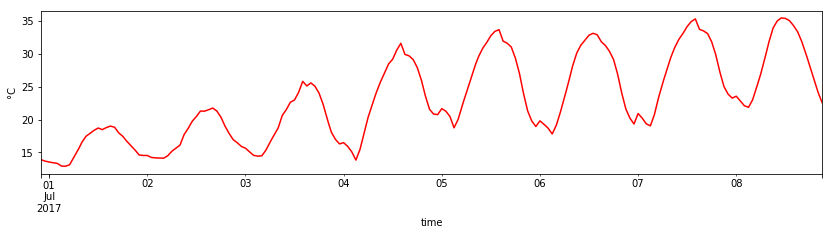

In [40]:
weatherdata['temperature'].plot(figsize=(14, 3), color='r' );  plt.ylabel('°C');

### Irradiation solaire

In [41]:
sundata = sun.buildmultidayDF( coords_grenoble, weatherdata.index, cloudCover = weatherdata['cloudCover']  )

/home/etienne/Projets/thermique_appart/py3/lib/python3.5/site-packages/pysolar/time.py:105: UserWarning: I don't know about leap seconds after 2015
  (leap_seconds_base_year + len(leap_seconds_adjustments) - 1)


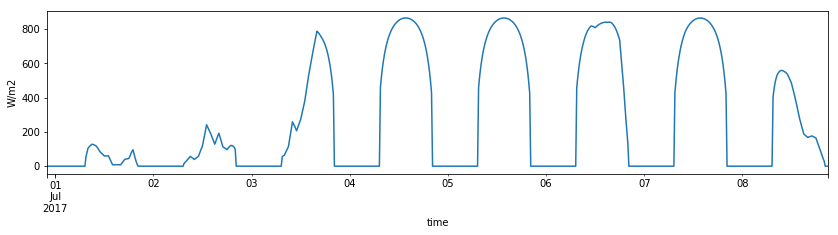

In [42]:
sundata['I0'].plot(figsize=(14, 3));  plt.ylabel('W/m2');

#### Projection sur les surfaces vitrées

In [43]:
sigma = 37  # deg, angle du toit
phi_C = 50  # deg, azimuth du toit

In [44]:
sunFlux_dict = {'flux_bastille':sun.projectDF( 37, 50, sundata ), 
                'flux_cuisine': sun.projectDF( 90, 50, sundata ),
                'flux_vercors': sun.projectDF( 37, 180+50, sundata),
                'flux_chambre': sun.projectDF( 90, 180+50, sundata )}

sunFlux = pd.DataFrame( sunFlux_dict )

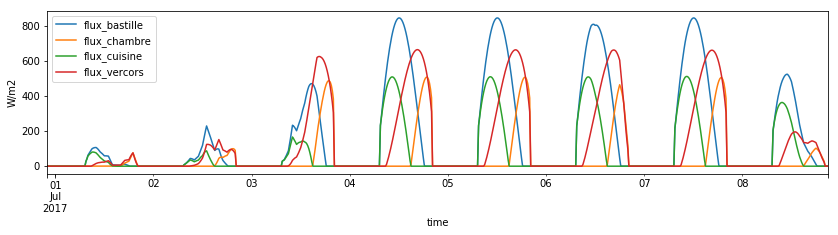

In [45]:
sunFlux.plot(figsize=(14, 3)); plt.ylabel('W/m2');

In [46]:
Facteur_g = 0.76 # Facteur solaire (prend en compte l'absorption et la ré-émission)

windows_size = { 'bastille':(1.2, 0.8),
            'cuisine1':(0.3, 0.72),
           'cuisine2':(0.3, 0.72),
            'chambre1':(0.3, 0.72),
            'chambre2':(0.3, 0.72),
            'vercors1':(0.6, 0.8),
            'vercors2':(0.6, 0.8),
            'sdb':(0.25, 0.25)
          }

In [47]:
def surf( k ):
    return windows_size[k][0]*windows_size[k][1]

In [48]:
weatherdata['flux_tot'] =( surf('bastille')*sunFlux_dict['flux_bastille'] \
            + 2*surf('cuisine1')*sunFlux_dict['flux_cuisine'] \
            + 2*surf('chambre1')*sunFlux_dict['flux_chambre']\
            + 2*surf('vercors1')*sunFlux_dict['flux_vercors'] ) * Facteur_g

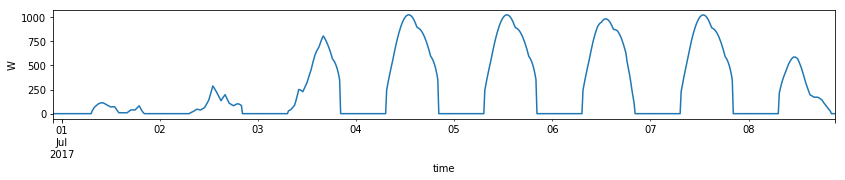

In [49]:
weatherdata['flux_tot'].plot(figsize=(14, 2)); plt.ylabel('W');

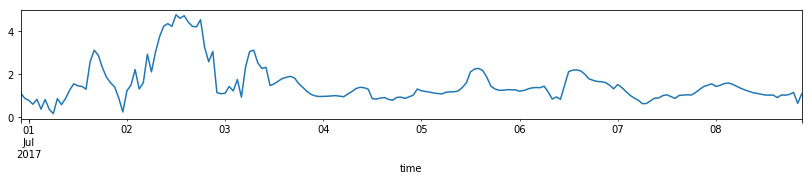

In [50]:
weatherdata['windSpeed'].plot(figsize=(14, 2))

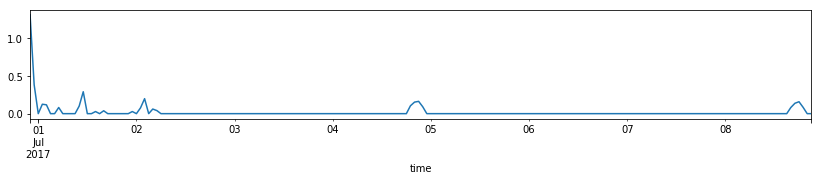

In [51]:
weatherdata['precipIntensity'].plot(figsize=(14, 2))

### Température intérieure mesurée

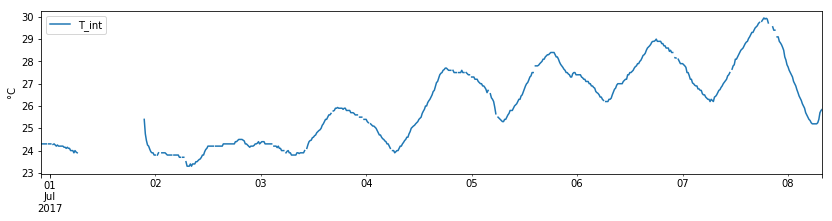

In [52]:
dataframefreq = '15min'
feeds =  { 'T_int': 3 }

Tmesure = getfeeds.builddataframe( feeds, dataframefreq , startdate=startday )
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [53]:
# Remove some data 
mask_start = pd.to_datetime( '28/06/2017 22:00' ).tz_localize('Europe/Paris')
mask_end = pd.to_datetime( '29/06/2017 10:00' ) .tz_localize('Europe/Paris')

mask = (Tmesure.index > mask_start) & (Tmesure.index < mask_end )

Tmesure['T_int'].loc[mask] = np.nan

In [54]:
Tmesure = Tmesure.resample('15min').interpolate()

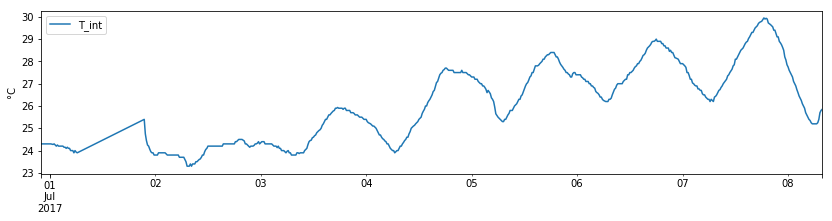

In [55]:
Tmesure.plot( figsize=(14, 3) ); plt.ylabel('°C');

In [56]:
# Merge
weatherdata['T_int'] = Tmesure['T_int'].interpolate()

# Save

In [57]:
weatherdata.to_pickle( 'weatherdata.pck' )

# Look

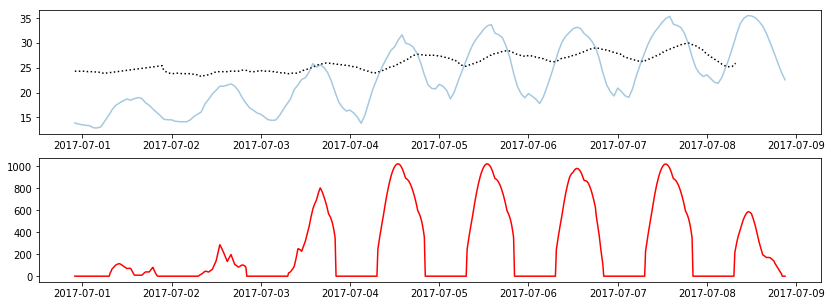

In [58]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot(weatherdata['T_int'] , ':k')
plt.plot(weatherdata['temperature'], alpha=0.4);

plt.subplot( 2, 1, 2 )
plt.plot(weatherdata['flux_tot'] , 'r'); 
